# Tutorial 06 - Pairwise co-occurrence

## Goals

- Implement an analysis of pairwise co-occurrence during sharp-wave ripple events
- Apply a permutation test (shuffle) to determine levels of chance co-occurrence

## Compute pairwise co-occurrence during SWRs

In [1]:
# Import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt
import scipy.signal

# Define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R042-2013-08-18')

In [2]:
# Load the info file, which contains experiment-specific information
sys.path.append(data_folder)
import r042d3 as info

In [3]:
# Determine times of interest
# Here let's compare the co-occurrence during prerecord and postrecord
prerecord_start = info.task_times['prerecord'].start
prerecord_stop = info.task_times['prerecord'].stop

postrecord_start = info.task_times['postrecord'].start
postrecord_stop = info.task_times['postrecord'].stop

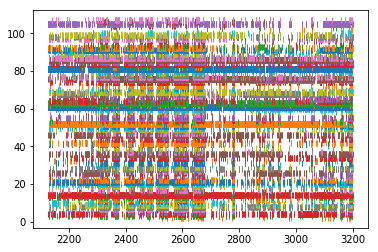

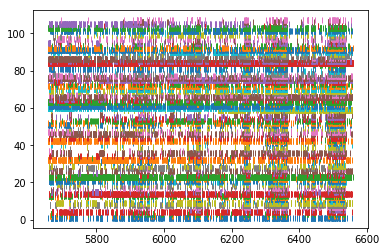

n_neurons: 107


In [4]:
# Load spikes (.t and ._t) from this experiment
spikes = nept.load_spikes(data_folder)

# Restrict the spikes to the prerecord
spikes_pre = [spiketrain.time_slice(prerecord_start, prerecord_stop) for spiketrain in spikes]

# Restrict the spikes to the postrecord
spikes_post = [spiketrain.time_slice(postrecord_start, postrecord_stop) for spiketrain in spikes]

# Plot the spikes
for idx, spiketrain in enumerate(spikes_pre):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx, '|')
plt.show()

# Plot the spikes
for idx, spiketrain in enumerate(spikes_post):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx, '|')
plt.show()

# Print the number of neurons we're working with
print('n_neurons:', len(spikes))

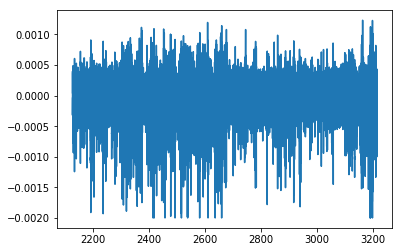

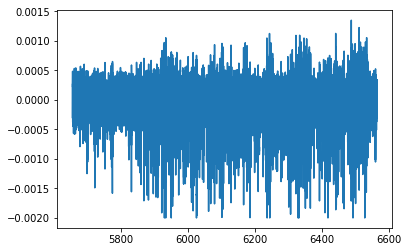

In [5]:
# Load LFP with good sharp-wave ripples
lfp = nept.load_lfp(os.path.join(data_folder, info.lfp_swr_filename))

# Restrict the LFP to the prerecord
lfp_pre = lfp.time_slice(prerecord_start, prerecord_stop)

# Restrict the LFP to the postrecord
lfp_post = lfp.time_slice(postrecord_start, postrecord_stop)

# Plot the LFP during the prerecord
plt.plot(lfp_pre.time, lfp_pre.data)
plt.show()

# Plot the LFP during the postrecord
plt.plot(lfp_post.time, lfp_post.data)
plt.show()

In [6]:
# Find sharp-wave ripple (SWR) epochs
z_thresh = 3.0
merge_thresh = 0.02
min_length = 0.01

swrs_pre = nept.detect_swr_hilbert(lfp_pre, 
                                   fs=info.fs, 
                                   thresh=swr_thresh, 
                                   z_thresh=z_thresh,
                                   merge_thresh=merge_thresh, 
                                   min_length=min_length)

swrs_post = nept.detect_swr_hilbert(lfp_post, 
                                    fs=info.fs,
                                    z_thresh=z_thresh,
                                    merge_thresh=merge_thresh, 
                                    min_length=min_length)

print('Number of prerecord SWRs:', swrs_pre.n_epochs)
print('Number of postrecord SWRs:', swrs_post.n_epochs)

Number of prerecord SWRs: 506
Number of postrecord SWRs: 482


In [7]:
# Filter the SWR epochs to only those with a certain minimum number of neurons involved
min_involved = 4

swrs_pre = nept.find_multi_in_epochs(spikes_pre, swrs_pre, min_involved=min_involved)

swrs_post = nept.find_multi_in_epochs(spikes_post, swrs_post, min_involved=min_involved)

print('Number of prerecord SWRs:', swrs_pre.n_epochs)
print('Number of postrecord SWRs:', swrs_post.n_epochs)

Number of prerecord SWRs: 451
Number of postrecord SWRs: 457


In [8]:
# Filter and bin spikes to those that occur during the swrs
counts_swr_pre = nept.spike_counts(spikes_pre, swrs_pre)

counts_swr_post = nept.spike_counts(spikes_post, swrs_post)

# Verify that counts_swr is shape (n_neurons x n_swrs)
print('Shape of prerecord counts_swr_pre:', counts_swr_pre.shape)
print('Shape of postrecord counts_swr_post:', counts_swr_post.shape)

Shape of prerecord counts_swr_pre: (107, 451)
Shape of postrecord counts_swr_post: (107, 457)


In [9]:
# Make a mask for the neurons recorded from the same tetrode
tetrode_mask = nept.get_tetrode_mask(spikes)

In [10]:
# Compute the pairwise co-occurrence
probs_pre = nept.compute_cooccur(counts_swr_pre, tetrode_mask, num_shuffles=100)
probs_post = nept.compute_cooccur(counts_swr_post, tetrode_mask, num_shuffles=100)

print(probs_pre.keys())

dict_keys(['active', 'expected', 'observed', 'shuffle', 'zscore'])


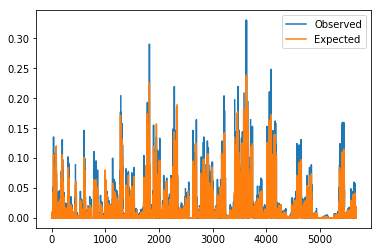

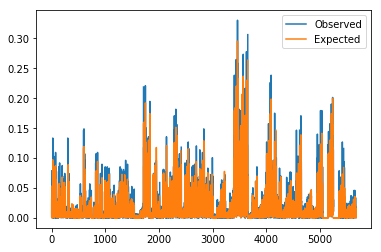

In [11]:
for probs in [probs_pre, probs_post]:
    plt.plot(probs['observed'])
    plt.plot(probs['expected'])
    plt.legend(['Observed', 'Expected'])
    plt.show()

In [12]:
# Make a function to plot the pairwise co-occurrence
def plot_cooccur(pre, post, title):
    fig, ax = plt.subplots()

    ind = np.arange(1)
    width = 0.5

    ax.bar(ind, pre, width)
    ax.bar(ind + width, post, width)
    
    ax.set_xticks([ind, ind+width])
    ax.set_xticklabels(['Prerecord', 'Postrecord'])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.title(title)
    plt.ylabel('Fraction')
    
    plt.show()

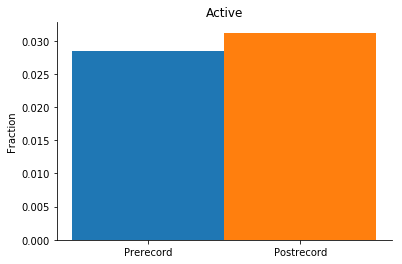

In [13]:
# Plot the weighted neuron participation during candidate events
# e.g. how active individual neurons are during the pre- and postrecord SWRs
active_pre = np.nansum(probs_pre['active']) / swrs_pre.n_epochs
active_post = np.nansum(probs_post['active']) / swrs_post.n_epochs
title = 'Active'

plot_cooccur(active_pre, active_post, title)

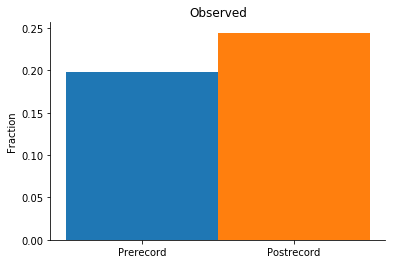

In [14]:
# Plot the weighted joint probability for neuron pairs
observed_pre = np.nansum(probs_pre['observed']) / swrs_pre.n_epochs
observed_post = np.nansum(probs_post['observed']) / swrs_post.n_epochs
title = 'Observed'

plot_cooccur(observed_pre, observed_post, title)

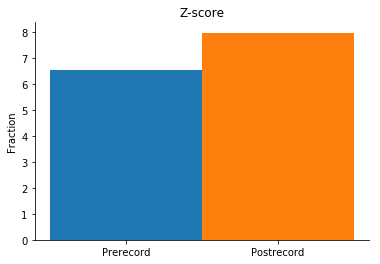

In [15]:
# Plot the weighted z-score coactivity
# e.g. are neurons co-occurring more often than expected by chance?
zscore_pre = np.nansum(probs_pre['zscore']) / swrs_pre.n_epochs
zscore_post = np.nansum(probs_post['zscore']) / swrs_post.n_epochs
title = 'Z-score'

plot_cooccur(zscore_pre, zscore_post, title)